In [ ]:
%pip install -q ipyleaflet==0.17.3 ipywidgets==8.0.6 jupyterlab_widgets==3.0.7

# EMIT methane point source plume complexes

You can learn more about how to access [this data](https://dev.ghg.center/api/stac/collections/nasa-jpl-plumes-emissions-updated) directly in [the VEDA documentation](https://nasa-impact.github.io/veda-docs).

In [28]:
import json
from datetime import date, timedelta

import ipywidgets as widgets
from ipyleaflet import Map, TileLayer, WidgetControl, GeoJSON, ScaleControl

In [2]:
try:
    from js import fetch

    async def fetch_json(url):
        response = await fetch(url)
        text = await response.text()
        return json.loads(text)
except: 
    import requests

    async def fetch_json(url):
        return requests.get(url).json()

In [3]:
GITHUB_URL = "https://raw.githubusercontent.com/NASA-IMPACT/veda-interactive-emission-plumes/main/content/Methane Metadata.json"
result = await fetch_json(GITHUB_URL)

def set_id(x):
    i, f  = x
    f["id"] = i
    return f

outlines = list(map(set_id, enumerate(filter(lambda f: f["geometry"]["type"] == "Polygon", result["features"]))))
centers = list(map(set_id, enumerate(filter(lambda f: f["geometry"]["type"] == "Point", result["features"]))))

In [4]:
# Get the ids for every item in the STAC collection
STAC_SEARCH_URL = "https://dev.ghg.center/api/stac/search?collections=nasa-jpl-plumes-emissions-updated&fields=id,geometry,properties&limit=1000"

result = await fetch_json(STAC_SEARCH_URL)
item_ids = result["features"]

Map(center=[39, -98], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

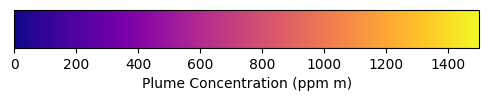

In [32]:
VMIN = 0
VMAX = 1500
IDS_ON_MAP = set()

m = Map(center=(39, -98), zoom=4, scroll_wheel_zoom=True)
m.layout.min_height="800px"

polygons = GeoJSON(
    data={"features": outlines}, 
    name='outlines',
    style={"color": "red"},
    hover_style={'fillColor': 'red', "fillOpacity": 0.5},
)

pins = GeoJSON(
    data={"features": centers}, 
    name='centers',
)

position_label = widgets.Label(layout=widgets.Layout(padding="10px", width="160px"), style={"background": "#ffffff66"})
def handle_interaction(**kwargs):
    if kwargs.get('type') == 'mousemove':
        lon, lat = kwargs.get('coordinates')
        position_label.value = f"W {round(lat, 4)}, N {round(lon, 4)}"

m.on_interaction(handle_interaction)

out = widgets.Output(layout=widgets.Layout(width="700px"))
colorbar_widget = widgets.Output(layout=widgets.Layout(width="450px"))

# create date range slider and callback for filtering data
start_date = date.fromisoformat(centers[0]["properties"]["UTC Time Observed"].split("T")[0])
end_date = date.fromisoformat(centers[-1]["properties"]["UTC Time Observed"].split("T")[0])

delta = end_date - start_date   # returns timedelta
dates = [(start_date + timedelta(days=i)).isoformat() for i in range(delta.days + 1)]

date_range = widgets.SelectionRangeSlider(
    options=dates,
    index=(0, len(dates)-1),
    orientation='horizontal',
    layout={'width': '300px'},
    style={'description_width': 'initial'},
    readout=False
)

start_label = widgets.Label(date_range.value[0])
end_label = widgets.Label(date_range.value[-1])

def filter_by_time(item, start, end):
    t = item["properties"]["UTC Time Observed"]
    return t > start and t < end

def filter_data(start, end):
    global outlines
    global centers
    
    func = lambda x: filter_by_time(x, start, end)
    pins.data = {"features": list(filter(func, centers))}
    polygons.data = {"features": list(filter(func, outlines))}
    
def dts_callback(dts):
    start = dts[0]
    end = dts[1]
    start_label.value = start
    end_label.value = end
    filter_data(start, end)

widgets.interactive_output(dts_callback, {"dts": date_range})

date_range_widget = widgets.HBox([start_label, date_range, end_label])

m.add(polygons)
m.add(pins)
m.add(WidgetControl(widget=out, position="bottomleft"))
m.add(WidgetControl(widget=date_range_widget, position="topright"))
m.add(WidgetControl(widget=colorbar_widget, position="topright", transparent_bg=True))
m.add(WidgetControl(widget=position_label, position="bottomright", transparent_bg=True))
m.add(ScaleControl(position='bottomright'))

@out.capture(clear_output=True)
def display_properties(feature):
    import pandas as pd
    
    p = {k: v for k, v in feature["properties"].items() if k not in ["style"]}
    display(pd.Series(p))
        
@colorbar_widget.capture(clear_output=True)
def create_colorbar():
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    
    colorbar_fig, ax = plt.subplots(figsize=(6, 1));
    colorbar_fig.subplots_adjust(bottom=0.5);

    cb = mpl.colorbar.ColorbarBase(
        ax, 
        cmap=mpl.cm.plasma,
        norm=mpl.colors.Normalize(vmin=VMIN, vmax=VMAX),
        orientation='horizontal'
    );
    cb.set_label('Plume Concentration (ppm m)');
    display(colorbar_fig)
    
def add_raster(feature):
    global item_ids
    global m
    
    props = feature["properties"]

    collection = "nasa-jpl-plumes-emissions-updated"
    assets = "ch4-plume-emissions"

    if feature["id"] not in IDS_ON_MAP:
        from shapely.geometry import shape
        
        subset = [i for i in item_ids if i["id"].startswith(props["Scene FID"])]
        outline_shape = shape(outlines[int(feature["id"])]["geometry"])

        for item in subset:
            if shape(item["geometry"]).intersects(outline_shape):
                TILE_URL = (
                    'https://dev.ghg.center/api/raster/stac/tiles/WebMercatorQuad/{z}/{x}/{y}@1x'
                    f'?collection={collection}&item={item["id"]}&assets={assets}'
                    f'&resampling=bilinear&bidx=1&colormap_name=plasma&rescale={VMIN}%2C{VMAX}&nodata=-9999'
                )
                m.add_layer(TileLayer(url=TILE_URL, max_zoom=24, show_loading=True))
        IDS_ON_MAP.add(feature["id"])
        
    if len(IDS_ON_MAP) == 1:
        create_colorbar()

    if m.zoom < 12:
        m.center = (props['Latitude of max concentration'], props['Longitude of max concentration'])
        m.zoom = 12
    
def set_date_range(feature):
    global date_range
    props = feature["properties"]
    
    t = date.fromisoformat(props["UTC Time Observed"].split("T")[0])
    date_range.value = ((t - timedelta(days=1)).isoformat(), (t + timedelta(days=1)).isoformat())

def on_click(event, feature, **kwargs):
    display_properties(feature)
    add_raster(feature)
    set_date_range(feature)


polygons.on_click(on_click)
pins.on_click(on_click)
m

⚠️ This visualization was created using a [jupyterlite-pyodide-kernel](https://github.com/jupyterlite/pyodide-kernel) and [voici](https://voici.readthedocs.io/en/latest/). It is rendered client-side (in your browser!) via the magic of [Wasm](https://webassembly.org/). This is an exciting and rapidly evolving space which means that this visualization is highly experimental and likely to break. ⚠️